In [1]:
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm
from collections import defaultdict, Counter
from scipy import stats
from itertools import combinations, islice
from sklearn import preprocessing

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
counts_iter = islice(read_json_gz_lines('../../data/actor-domain-counts.json/'), None)

ACTOR_DOMAIN_COUNTS = {
    (row['actor_id'], row['domain']): np.log(row['count'])
    for row in tqdm(counts_iter)
}

17979267it [01:22, 216905.85it/s]


In [4]:
ACTORS = list(set([aid for aid, _ in ACTOR_DOMAIN_COUNTS.keys()]))

In [5]:
DOMAINS = list(set([d for _, d in ACTOR_DOMAIN_COUNTS.keys()]))

In [6]:
PAIRS = [sorted([d1, d2]) for d1, d2 in combinations(DOMAINS, 2)]

In [7]:
ACTOR_TOTAL_LINKS = {}

for aid in tqdm(ACTORS):
    total = sum([ACTOR_DOMAIN_COUNTS.get((aid, d), 0) for d in DOMAINS])
    ACTOR_TOTAL_LINKS[aid] = total

100%|██████████| 8118326/8118326 [01:29<00:00, 90283.61it/s]


In [8]:
def build_corr_df(min_actor_links=0):
    
    domain_actor_counts = defaultdict(list)

    # Build domain -> (actor1 count, actor2 count...)
    for aid in tqdm(ACTORS):

        # Skip low-vol users.
        if ACTOR_TOTAL_LINKS[aid] < min_actor_links:
            continue

        for d in DOMAINS:
            domain_actor_counts[d].append(ACTOR_DOMAIN_COUNTS.get((aid, d), 0))
            
    # Actor count correlations for each pair.
    rows = []
    for d1, d2 in tqdm(PAIRS):

        c1, c2 = domain_actor_counts[d1], domain_actor_counts[d2]

        sp_corr, _ = stats.spearmanr(c1, c2)
        pr_corr, _ = stats.pearsonr(c1, c2)
        kt_corr, _ = stats.kendalltau(c1, c2)

        rows.append((d1, d2, sp_corr, pr_corr, kt_corr))
        
    df = pd.DataFrame(rows, columns=('d1', 'd2', 'sp_corr', 'pr_corr', 'kt_corr'))
    
    df['sp_scaled'] = preprocessing.scale(df.sp_corr)
    df['pr_scaled'] = preprocessing.scale(df.pr_corr)
    df['kt_scaled'] = preprocessing.scale(df.kt_corr)
    
    df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', 1)
    
    return df

In [9]:
def plot_df(df):
    
    pdf = pd.melt(df, ['label'], ['kt_scaled', 'sp_scaled', 'pr_scaled'])
    order = pdf[pdf.variable=='kt_scaled'].sort_values('value', ascending=False).label
    
    plt.figure(figsize=(5,30))
    sns.barplot(x='value', y='label', data=pdf, hue='variable', order=order)
    plt.show()

In [10]:
df = build_corr_df()

100%|██████████| 105/105 [21:25<00:00, 11.13s/it]


In [11]:
for c1, c2 in combinations(['sp_corr', 'kt_corr', 'pr_corr'], 2):
    print(c1, c2, stats.kendalltau(df[c1], df[c2]))

sp_corr kt_corr KendalltauResult(correlation=0.983150183150183, pvalue=5.695818513863508e-50)
sp_corr pr_corr KendalltauResult(correlation=0.8677655677655676, pvalue=2.562916673401266e-39)
kt_corr pr_corr KendalltauResult(correlation=0.8560439560439559, pvalue=2.6145918844317026e-38)


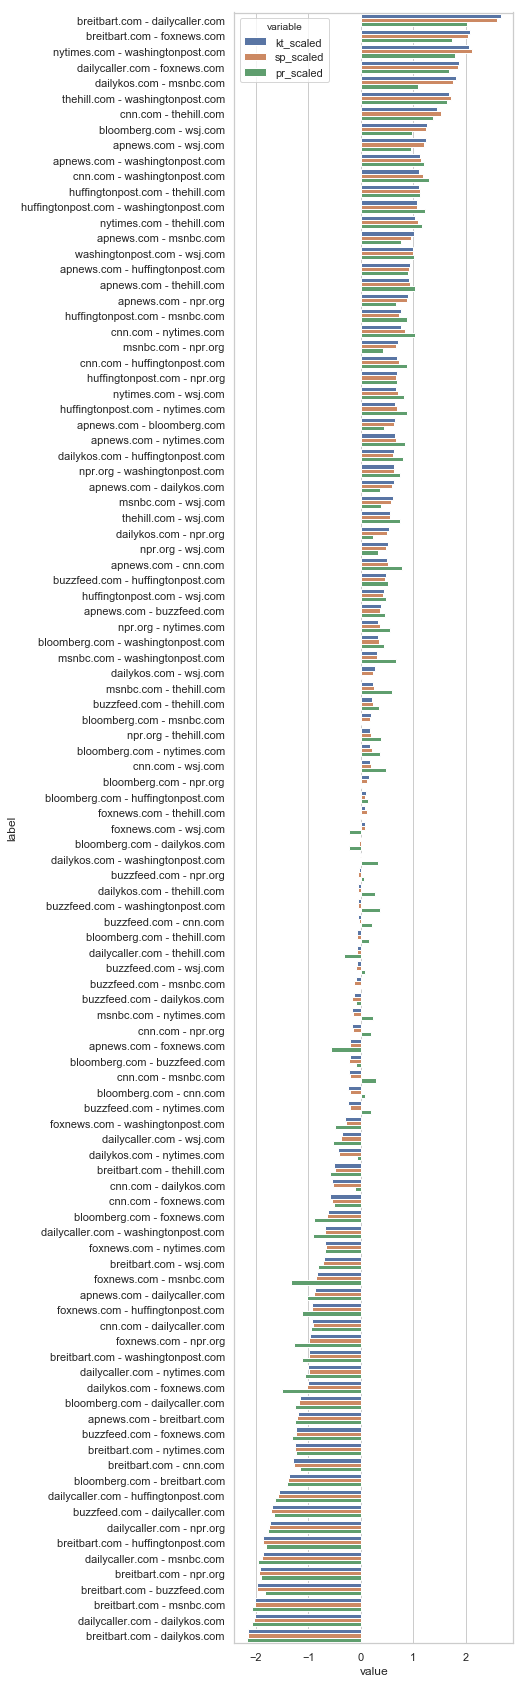

In [12]:
plot_df(df)

In [13]:
df10 = build_corr_df(10)

100%|██████████| 105/105 [00:57<00:00,  1.62it/s]


In [14]:
for c1, c2 in combinations(['sp_corr', 'kt_corr', 'pr_corr'], 2):
    print(c1, c2, stats.kendalltau(df10[c1], df10[c2]))

sp_corr kt_corr KendalltauResult(correlation=0.9516483516483515, pvalue=6.230897057653662e-47)
sp_corr pr_corr KendalltauResult(correlation=0.9410256410256409, pvalue=6.269342686798452e-46)
kt_corr pr_corr KendalltauResult(correlation=0.9549450549450548, pvalue=3.0276799688420264e-47)


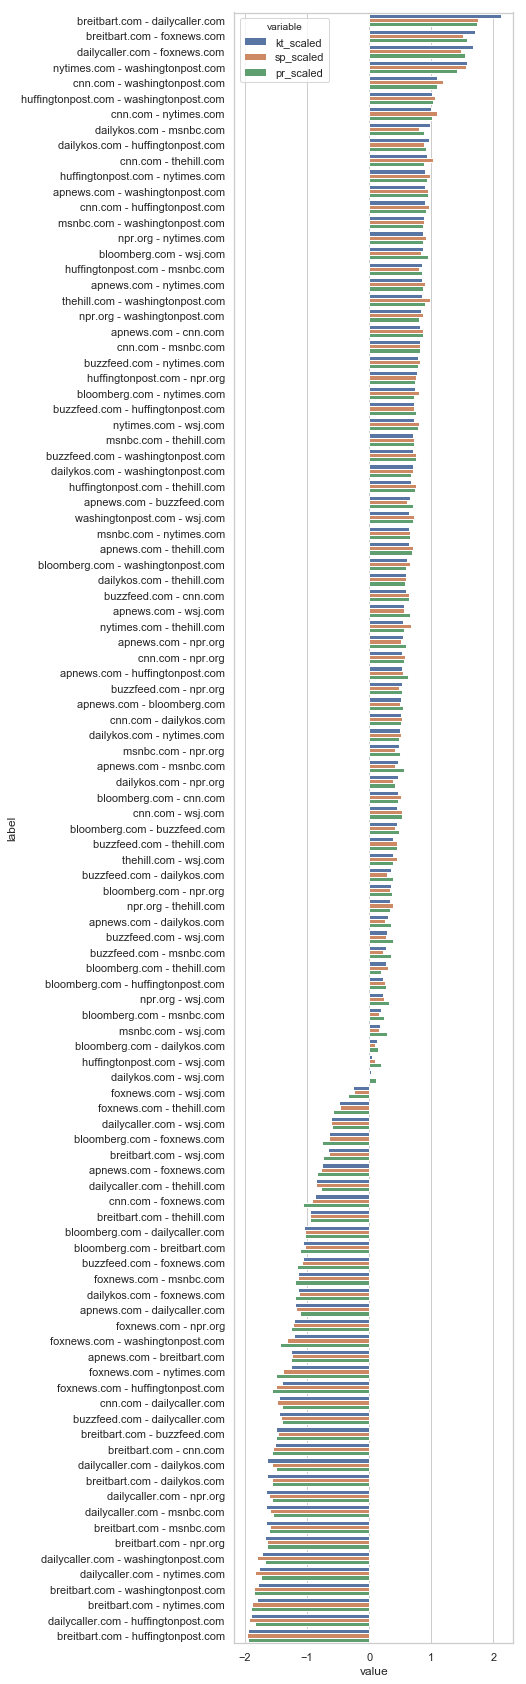

In [15]:
plot_df(df10)